# Day 06
## Feature engineering: fitting non-linear data
### Extra practice

In this notebook, we will see, how to handle cases, when it's impossible to linearly separate data.

At first, let's create linearly inseparable dataset

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)

Let's visualize it

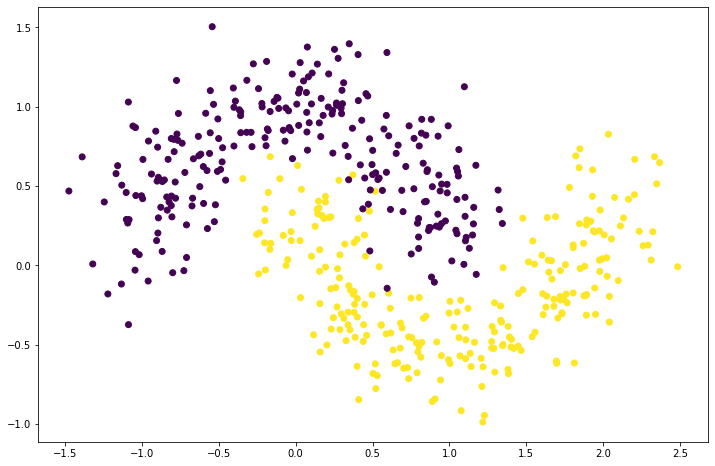

In [4]:
plt.figure(figsize=(12, 8))
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels);

First of all, let's try to fit simple Logistic Regression model and see the results:

In [7]:
# If you got ModuleNotFoundError:
# !pip install mlxtend

In [19]:
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import NotFittedError

from mlxtend.plotting import plot_decision_regions

In [10]:
param_grid_lr = {
    'penalty' : ['l1', 'l2'],
    'C' : np.linspace(0.1, 10, num=50)
}
grid_lr = GridSearchCV(
    LogisticRegression(solver='liblinear'), param_grid_lr, cv=3, verbose=1)
grid_lr.fit(moons_points, moons_labels);
lr = grid_lr.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([ 0.1       ,  0.30204082,  0.50408163,  0.70612245,  0.90816327,
        1.11020408,  1.3122449 ,  1.51428571,  1.71632653,  1.91836735,
        2.12040816,  2.32244898,  2.5244898 ,  2.72653061,  2.92857143,
        3.13061224,  3.33265306,  3.53469388,  3.73673469,  3.93877551,
        4.14081633,  4.34285714,  4.54489796,  4.74693878,  4.94897959,
        5.15102041,  5.35306122,  5.55510204,  5.75714286,  5.95918367,
        6.16122449,  6.36326531,  6.56530612,  6.76734694,  6.96938776,
        7.17142857,  7.37346939,  7.5755102 ,  7.77755102,  7.97959184,
        8.18163265,  8.38367347,  8.58571429,  8.7877551 ,  8.98979592,
        9.19183673,  9.39387755,  9.59591837,  9.79795918, 10.        ]),
                         'penalty': ['l1', 'l2']},
             verbose=1)

Function to visualize decision boundaries. If model not fitted yet, It will fit model and then plot it

In [14]:
def plot_decisions(X, y, estimator, scorer, score_name, title, figsize=(16,9), show_figure=True):
    try:
        estimator.predict(X)
    except NotFittedError as e:
        estimator.fit(X, y)
    
    score = scorer(y, estimator.predict(X))
    
    if show_figure: plt.figure(figsize=figsize)
    plt.title(f"{title} ({score_name} - {score})")
    plot_decision_regions(X, y, estimator, legend=0)
    if show_figure: plt.show()

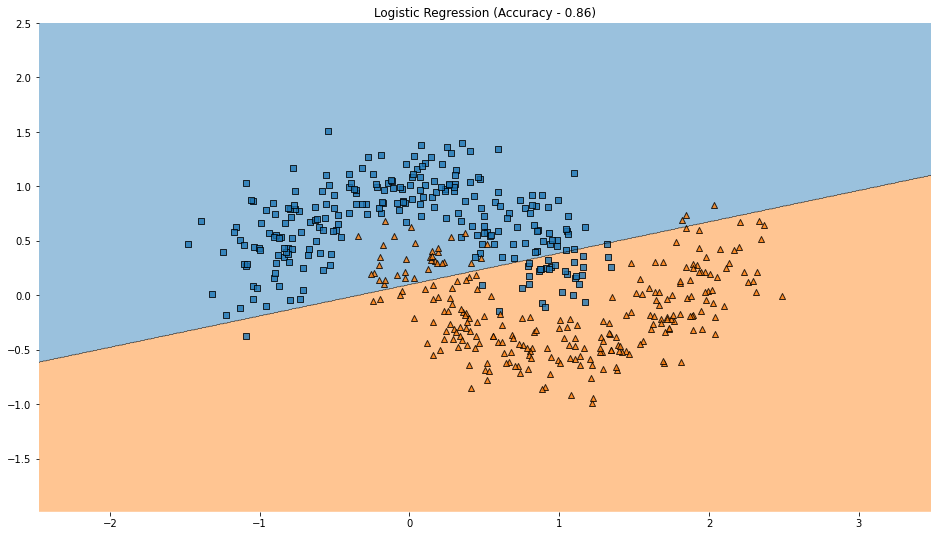

In [15]:
plot_decisions(
    moons_points, moons_labels,
    lr, accuracy_score, "Accuracy", 
    "Logistic Regression"
)

What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, for now we will present one of the simpliest ways

In particular case simple [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from tqdm import tqdm

6it [00:02,  2.71it/s]


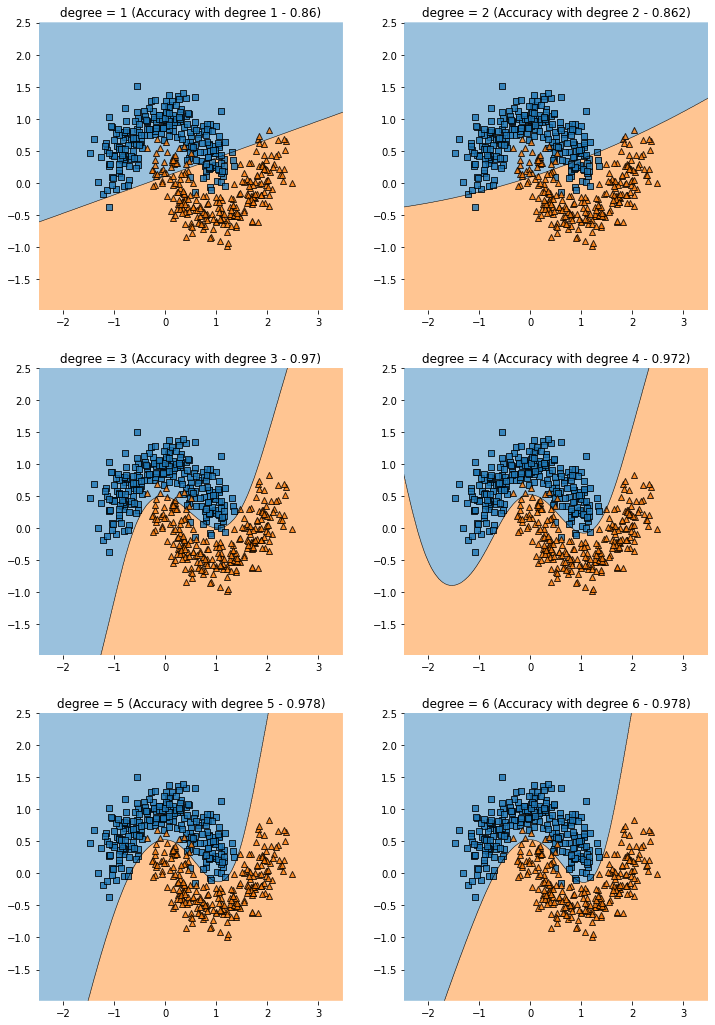

CPU times: user 5.91 s, sys: 1.09 s, total: 7 s
Wall time: 2.72 s


In [20]:
%%time
degrees = np.arange(1, 7)
plt.figure(figsize=(12, 18))

for i, degree in tqdm(enumerate(degrees)):
    plt.subplot(3,2,i+1)
    plot_decisions(moons_points, moons_labels, 
                   Pipeline([
                       ('polynomial_features', PolynomialFeatures(degree=degree)),
                       ('lr_clf', lr)
                   ]),
                   accuracy_score, f"Accuracy with degree {degree}",
                   f"degree = {degree}", show_figure=False)
plt.show()

#### Harder Problem

Let's make this task a bit more challenging via upgrading dataset:

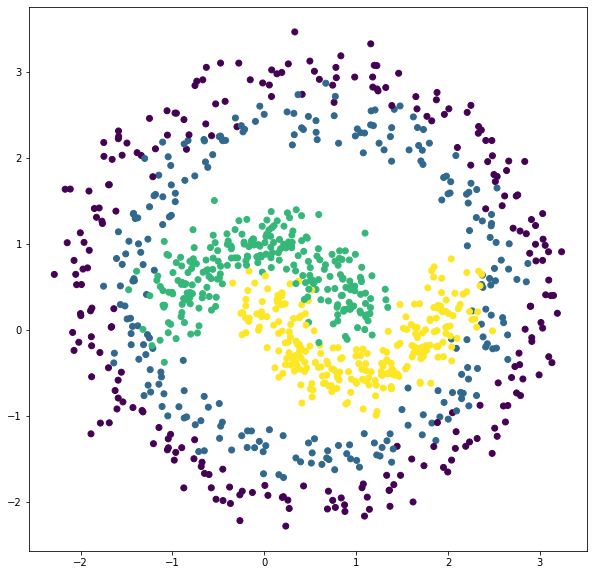

In [23]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2))

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=labels);

To start it is worthwhile to split the sample in order to
adequately evaluate the metrics and model performance

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    points, 
    labels,
    test_size=0.25,
    random_state=42, 
    stratify=labels
)

In [25]:
# Helper for handy printing
def show_accuracy(estimator):
    pred_test = estimator.predict(x_test)
    pred_train = estimator.predict(x_train)
    print(f"Accuracy on test data : {accuracy_score(y_test, pred_test)}")
    print(f"Accuracy on train data : {accuracy_score(y_train, pred_train)}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Accuracy on test data : 0.392
Accuracy on train data : 0.4093333333333333


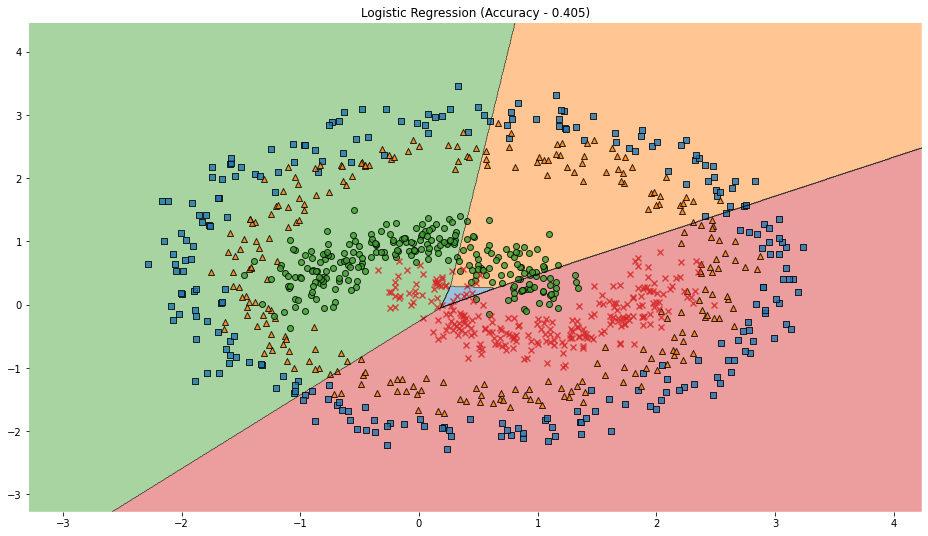

In [26]:
# Begin with logistic regression. Obviously, we won't get anything good, but just look at it
param_grid_lr = {
    'penalty' : ['l1', 'l2'],
    'C' : np.linspace(0.1, 10, num=50)
}
grid_lr = GridSearchCV(
    LogisticRegression(solver='liblinear', multi_class='ovr'), 
    param_grid_lr,
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_lr.fit(x_train, y_train);
best_lr_clf = grid_lr.best_estimator_

show_accuracy(best_lr_clf)
plot_decisions(
    points, 
    labels, 
    best_lr_clf, 
    accuracy_score, 
    "Accuracy", 
    "Logistic Regression")

Okay, let's see, what we can do with Polynomial features

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Accuracy on test data : 0.912
Accuracy on train data : 0.948


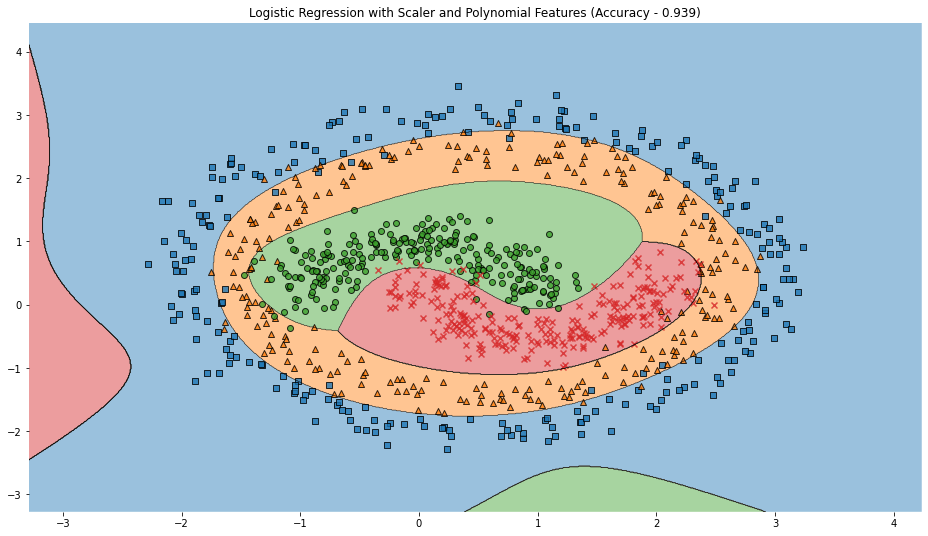

In [29]:
pipeline_lr_with_pf = Pipeline([
    ("pol_features", PolynomialFeatures()),
    ("lr_clf", LogisticRegression(solver="liblinear", multi_class="ovr"))
])
param_grid_lr_with_pf = {
    'pol_features__degree' : np.arange(5, 7),
    'lr_clf__penalty' : ['l1', 'l2'],
    'lr_clf__C' : np.linspace(0.1, 10, num=10)
}

grid_lr_with_pf = GridSearchCV(
    pipeline_lr_with_pf, 
    param_grid_lr_with_pf,
    cv=3, verbose=1, n_jobs=-1)
grid_lr_with_pf.fit(x_train, y_train);
best_lr_with_pf = grid_lr_with_pf.best_estimator_

show_accuracy(best_lr_with_pf)
plot_decisions(
    points, labels,
    best_lr_with_pf, 
    accuracy_score, "Accuracy", 
    "Logistic Regression with Scaler and Polynomial Features")

Okay, now we know how to create new features for sklearn pipeline. The problem is - with PolynomialFeatures transformer we can only create polynomial features ($x_1^2, x_2^2, 2x_1x_2, \dots$) - what if we want to make different functions (for example $sin(x)$?). Well, in that case [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) can help us. Let's see, how it works. 

In [31]:
from sklearn.preprocessing import FunctionTransformer

In [32]:
# This function will add 3 extra features for our data
def add_extra_features(X):
    return np.hstack((X, np.sin(X), np.cos(X), np.exp(X)))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Accuracy on test data : 0.912
Accuracy on train data : 0.9506666666666667


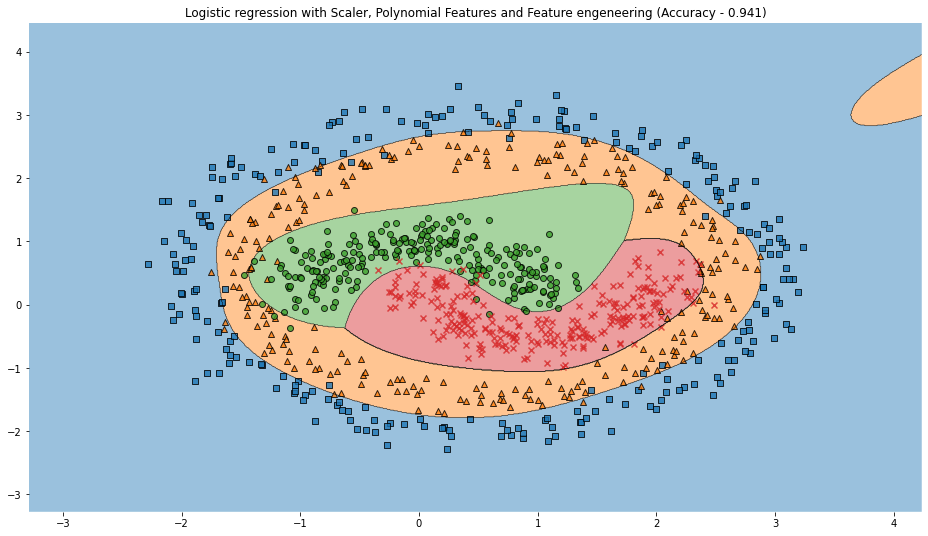

In [34]:
pipeline_lr_with_pf_and_fe = Pipeline([
    ('add_features', FunctionTransformer(add_extra_features, validate=True)),
    ('pol_features', PolynomialFeatures()),
    ('lr_clf', LogisticRegression(solver='liblinear', multi_class='ovr'))
])
param_grid_lr_with_pf_and_fe = {
    'pol_features__degree' : np.arange(3, 4),
    'lr_clf__C' : np.linspace(0.1, 10, num=10)
}
grid_lr_with_pf_and_fe = GridSearchCV(
    pipeline_lr_with_pf_and_fe, 
    param_grid_lr_with_pf_and_fe,
    cv=3, verbose=10, n_jobs=-1)
grid_lr_with_pf_and_fe.fit(x_train, y_train);
best_lr_with_pf_and_fe = grid_lr_with_pf_and_fe.best_estimator_

show_accuracy(best_lr_with_pf_and_fe)
plot_decisions(
    points, labels, 
    best_lr_with_pf_and_fe, accuracy_score, 
    "Accuracy", 
    "Logistic regression with Scaler, Polynomial Features and Feature engeneering")

At last, It often benefitial to normalize our data. Let's try add scaler to our pipeline and see final results

In [35]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Accuracy on test data : 0.92
Accuracy on train data : 0.948


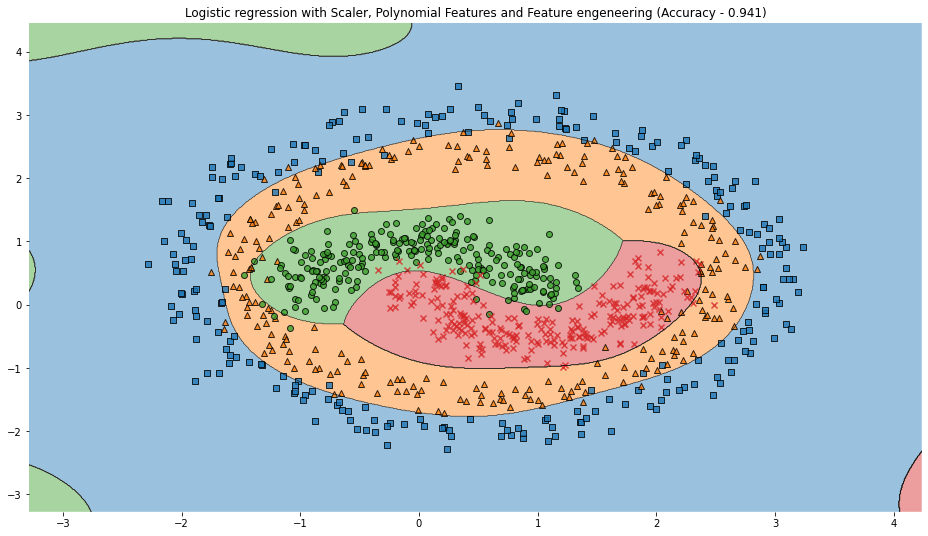

In [37]:
pipeline_lr_with_pf_and_fe = Pipeline([
    ('add_features', FunctionTransformer(add_extra_features, validate=True)),
    ('pol_features', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lr_clf', LogisticRegression(solver='liblinear', multi_class='ovr'))
])
param_grid_lr_with_pf_and_fe = {
    'pol_features__degree' : np.arange(3, 4),
    'lr_clf__C' : np.linspace(0.1, 10, num=10),
    'scaler': [StandardScaler(), MinMaxScaler()]
}
grid_lr_with_pf_and_fe = GridSearchCV(
    pipeline_lr_with_pf_and_fe, 
    param_grid_lr_with_pf_and_fe,
    cv=3, verbose=1, n_jobs=-1)
grid_lr_with_pf_and_fe.fit(x_train, y_train);

best_lr_with_pf_and_fe = grid_lr_with_pf_and_fe.best_estimator_
show_accuracy(best_lr_with_pf_and_fe)

plot_decisions(
    points, labels, best_lr_with_pf_and_fe, accuracy_score, "Accuracy", 
    "Logistic regression with Scaler, Polynomial Features and Feature engeneering")

----

### TBD: Feature selection

Actually, when creating extra features with FunctionTransformer and PolynomialFeatures we create a lot of new features. Let's see that

In [66]:
fe_pipe = Pipeline([
    ('add_features', FunctionTransformer(add_extra_features, validate=True)),
    ('pol_features', PolynomialFeatures(2)),
])

transf = fe_pipe.fit_transform(x_train)
print(f"Num of features before fe: {x_train.shape[1]}")
print(f"Num of features after fe (degree=2): {transf.shape[1]}")

Num of features before fe: 2
Num of features after fe (degree=2): 45


It is just using `degree=2`. See, what happens, when we increase degree...

In [67]:
fe_pipe = Pipeline([
    ('add_features', FunctionTransformer(add_extra_features, validate=True)),
    ('pol_features', PolynomialFeatures(6)),
])

transf = fe_pipe.fit_transform(x_train)
print(f"Num of features before fe: {x_train.shape[1]}")
print(f"Num of features after fe (degree=2): {transf.shape[1]}")

Num of features before fe: 2
Num of features after fe (degree=2): 3003


Intuitevly, we don't need so many features. Let's see correlation matrix

In [68]:
import pandas as pd
import seaborn as sns

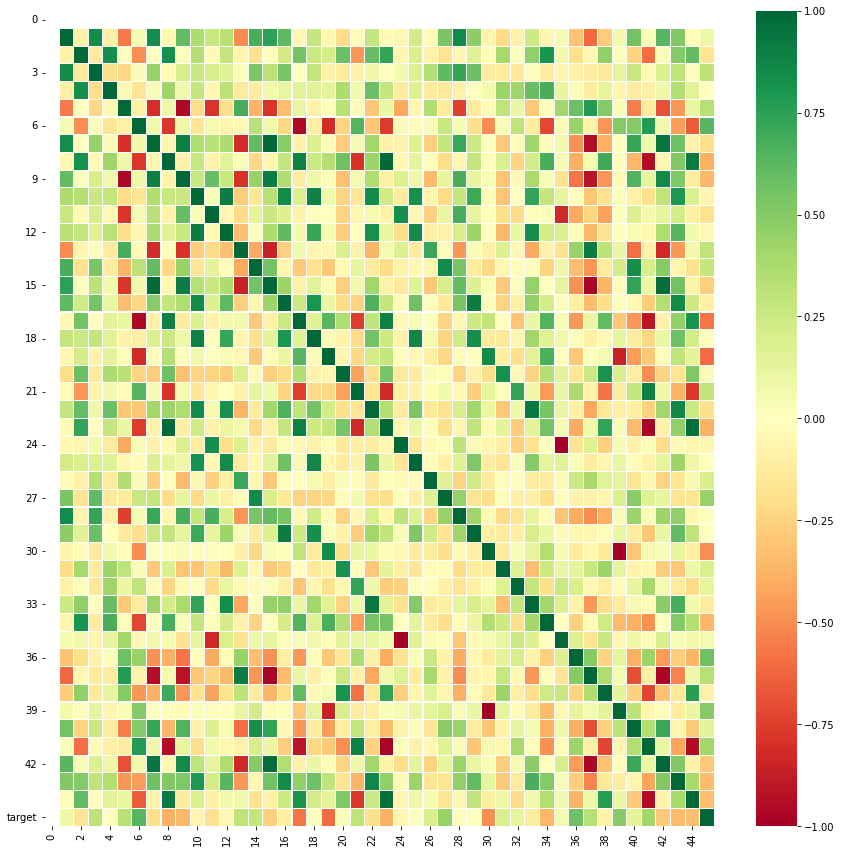

In [69]:
fe_pipe = Pipeline([
    ('add_features', FunctionTransformer(add_extra_features, validate=True)),
    ('pol_features', PolynomialFeatures(2)),
])

transf = fe_pipe.fit_transform(x_train)

df = pd.DataFrame(
    np.hstack([transf, y_train[:, None]]), 
    columns=[str(i) for i in range(transf.shape[1])] + ["target"])

sns.heatmap(
    df.corr(),cmap='RdYlGn',linewidths=0.1
)
fig=plt.gcf()
fig.set_size_inches(15,15)
plt.show()

Okay, there are features, which are useless. We can easily discard them and we won't have any decline in metrics (sometimes even otherwise we'll see score increasing).

Technique of choosing, with features are relevant and which aren't is called [Feature Selection](https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/). We will see, how it works in future (for now, you can read blogpost about it). 

Stay tuned

---